In [8]:
import json
from datetime import datetime

def process_date(date_str):
    try:
        date_obj = datetime.strptime(date_str, "%b %d, %Y")
        return date_obj.year, date_obj.month
    except:
        return None, None

# 讀取原始 JSON 檔案
with open('games.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

cleaned_data = {}

for game_id, game_info in data.items():
    # 先檢查發行年份
    year, month = process_date(game_info.get('release_date', ''))
    
    # 如果年份小於 2015 或無法解析年份，則跳過這筆資料
    if not year or year < 2015:
        continue
        
    cleaned_game = {}
    
    # 處理日期
    cleaned_game['Release_year'] = year
    cleaned_game['Release_month'] = month
    
    # 處理平台
    cleaned_game['Windows'] = game_info.get('windows', False)
    cleaned_game['Mac'] = game_info.get('mac', False)
    cleaned_game['Linux'] = game_info.get('linux', False)
    
    # 計算平台數量
    platform_count = sum([
        1 if game_info.get('windows', False) else 0,
        1 if game_info.get('mac', False) else 0,
        1 if game_info.get('linux', False) else 0
    ])
    cleaned_game['Platform_count'] = platform_count
    
    # 語言相關
    cleaned_game['Language_count'] = len(game_info.get('supported_languages', []))
    cleaned_game['Audio_language_count'] = len(game_info.get('full_audio_languages', []))
    
    # 成就相關
    cleaned_game['Has_achievements'] = bool(game_info.get('achievements', 0))
    cleaned_game['Achievement_count'] = game_info.get('achievements', 0)
    
    # 開發商和發行商
    cleaned_game['Developer_encoded'] = game_info.get('developers', [''])[0] if game_info.get('developers') else ''
    cleaned_game['Publisher_encoded'] = game_info.get('publishers', [''])[0] if game_info.get('publishers') else ''
    
    # 媒體數量
    cleaned_game['Screenshot_count'] = len(game_info.get('screenshots', []))
    cleaned_game['Movie_count'] = len(game_info.get('movies', []))
    
    # 分類、類型和標籤數量
    cleaned_game['Categories_count'] = len(game_info.get('categories', []))
    cleaned_game['Genres_count'] = len(game_info.get('genres', []))
    cleaned_game['Tags_count'] = len(game_info.get('tags', {}))
    
    # 價格
    cleaned_game['Price'] = game_info.get('price', 0)
    
    # 將清理後的遊戲資料加入新字典
    cleaned_data[game_id] = cleaned_game

# 將清理後的資料寫入新的 JSON 檔案
with open('cleaned_output.json', 'w', encoding='utf-8') as f:
    json.dump(cleaned_data, f, ensure_ascii=False, indent=4)

print(f'已完成清理，共保留 {len(cleaned_data)} 筆 2015 年後的資料')

已完成清理，共保留 93497 筆 2015 年後的資料


原始資料數量: 93497
移除價格為 0 後的資料數量: 74244
移除價格極端值後的資料筆數: 73298

特徵工程後的基本統計資訊:
特徵數量: 43

數值型特徵的描述性統計:
       Platform_count  Language_count  Audio_language_count  \
count    7.329800e+04    7.329800e+04          7.329800e+04   
mean     7.134703e-17    1.861227e-17         -7.755112e-19   
std      1.000007e+00    1.000007e+00          1.000007e+00   
min     -5.273220e-01   -4.625045e+00         -8.355202e-01   
25%     -5.273220e-01   -8.093494e-01         -8.355202e-01   
50%     -5.273220e-01   -8.093494e-01         -8.355202e-01   
75%     -5.273220e-01    1.055168e+00          8.873558e-01   
max      1.945805e+00    1.888271e+00          2.076639e+00   

       Achievement_count  Screenshot_count   Movie_count  Categories_count  \
count       7.329800e+04      7.329800e+04  7.329800e+04      7.329800e+04   
mean       -5.118374e-17     -1.938778e-17  1.783676e-17      1.054695e-16   
std         1.000007e+00      1.000007e+00  1.000007e+00      1.000007e+00   
min        -1.017540e+00 

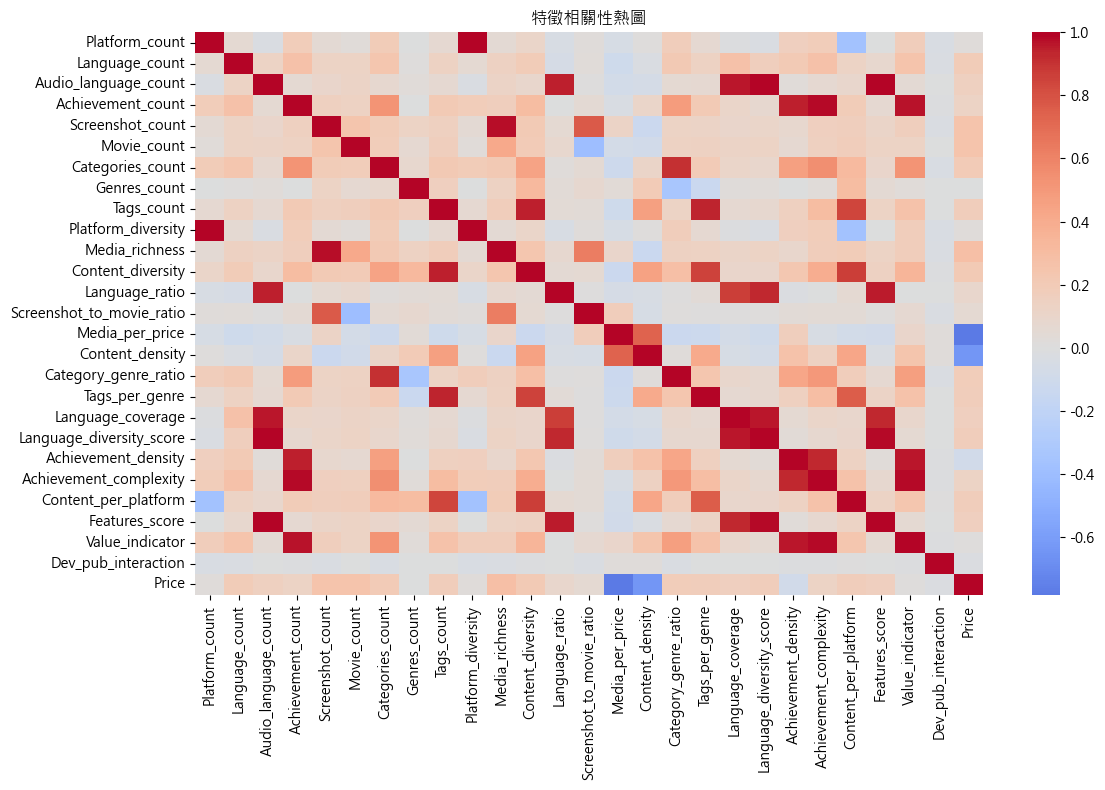


所有特徵名稱:
['Release_year', 'Release_month', 'Windows', 'Mac', 'Linux', 'Platform_count', 'Language_count', 'Audio_language_count', 'Has_achievements', 'Achievement_count', 'Screenshot_count', 'Movie_count', 'Categories_count', 'Genres_count', 'Tags_count', 'Price', 'Platform_diversity', 'Media_richness', 'Screenshot_to_movie_ratio', 'Media_per_price', 'Content_diversity', 'Content_density', 'Category_genre_ratio', 'Tags_per_genre', 'Language_ratio', 'Language_coverage', 'Language_diversity_score', 'Achievement_density', 'Achievement_complexity', 'Is_holiday_release', 'Same_dev_pub', 'Dev_pub_interaction', 'Content_per_platform', 'Features_score', 'Value_indicator', 'Season_Winter', 'Season_Spring', 'Season_Summer', 'Season_Fall', 'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4']


In [4]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 讀取 JSON 檔案
with open('cleaned_output.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 設定中文字型（如果需要顯示中文）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 將字典轉換為 DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# 移除價格為 0 的遊戲
print(f"原始資料數量: {len(df)}")
df = df[df['Price'] > 0]
print(f"移除價格為 0 後的資料數量: {len(df)}")

# 1. 處理極端值
def remove_price_outliers(df, column, n_std=3):
    mean = df[column].mean()
    std = df[column].std()
    return df[np.abs(df[column] - mean) <= (n_std * std)]

# 移除價格極端值
df = remove_price_outliers(df, 'Price')
print(f"移除價格極端值後的資料筆數: {len(df)}")

# 2. 增強特徵工程
# 2.1 基本平台特徵
df['Platform_count'] = df[['Windows', 'Mac', 'Linux']].sum(axis=1)
df['Platform_diversity'] = df['Platform_count'] / 3

# 2.2 媒體內容特徵
df['Media_richness'] = df['Screenshot_count'] + df['Movie_count']
df['Screenshot_to_movie_ratio'] = df['Screenshot_count'] / (df['Movie_count'] + 1)
df['Media_per_price'] = df['Media_richness'] / df['Price']

# 2.3 內容多樣性特徵
df['Content_diversity'] = df['Categories_count'] + df['Genres_count'] + df['Tags_count']
df['Content_density'] = df['Content_diversity'] / df['Price']
df['Category_genre_ratio'] = df['Categories_count'] / (df['Genres_count'] + 1)
df['Tags_per_genre'] = df['Tags_count'] / (df['Genres_count'] + 1)

# 2.4 語言特徵
df['Language_ratio'] = df['Audio_language_count'] / (df['Language_count'] + 1)
df['Language_coverage'] = df['Audio_language_count'] / df['Language_count'].max()
df['Language_diversity_score'] = (df['Language_count'] * df['Audio_language_count']) ** 0.5

# 2.5 成就相關特徵
df['Achievement_density'] = df['Achievement_count'] / (df['Price'] + 1)
df['Has_achievements'] = (df['Achievement_count'] > 0).astype(int)
df['Achievement_complexity'] = df['Achievement_count'] * df['Content_diversity']

# 2.6 發行時間特徵
df['Release_quarter'] = pd.to_datetime(df['Release_month'].astype(str) + '/1/' + 
                                     df['Release_year'].astype(str)).dt.quarter
df['Is_holiday_release'] = ((df['Release_month'] == 11) | 
                           (df['Release_month'] == 12)).astype(int)

# 2.7 開發商/發行商特徵
# 使用 LabelEncoder 重新編碼開發商和發行商
le_dev = LabelEncoder()
le_pub = LabelEncoder()
df['Developer_encoded_num'] = le_dev.fit_transform(df['Developer_encoded'])
df['Publisher_encoded_num'] = le_pub.fit_transform(df['Publisher_encoded'])
df['Same_dev_pub'] = (df['Developer_encoded'] == df['Publisher_encoded']).astype(int)
df['Dev_pub_interaction'] = df['Developer_encoded_num'] * df['Publisher_encoded_num']

# 2.8 複合特徵
df['Content_per_platform'] = df['Content_diversity'] / df['Platform_count']
df['Features_score'] = (df['Content_diversity'] * df['Platform_diversity'] * 
                       df['Language_diversity_score']) ** (1/3)
df['Value_indicator'] = (df['Content_diversity'] * df['Media_richness'] * 
                        df['Achievement_count']) / df['Price']

# 3. 特徵變換和縮放
# 3.1 選擇需要縮放的數值型特徵
numeric_features = [
    'Platform_count', 'Language_count', 'Audio_language_count',
    'Achievement_count', 'Screenshot_count', 'Movie_count',
    'Categories_count', 'Genres_count', 'Tags_count',
    'Platform_diversity', 'Media_richness', 'Content_diversity',
    'Language_ratio', 'Screenshot_to_movie_ratio', 'Media_per_price',
    'Content_density', 'Category_genre_ratio', 'Tags_per_genre',
    'Language_coverage', 'Language_diversity_score', 'Achievement_density',
    'Achievement_complexity', 'Content_per_platform', 'Features_score',
    'Value_indicator', 'Dev_pub_interaction'
]

# 3.2 使用 PowerTransformer 處理偏態
pt = PowerTransformer(method='yeo-johnson')
df[numeric_features] = pt.fit_transform(df[numeric_features])

# 3.3 標準化特徵
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# 4. 類別特徵處理
# 4.1 季節編碼
df['Season'] = pd.cut(df['Release_month'], 
                     bins=[0, 3, 6, 9, 12], 
                     labels=['Winter', 'Spring', 'Summer', 'Fall'])
df = pd.get_dummies(df, columns=['Season'])

# 4.2 季度編碼
df = pd.get_dummies(df, columns=['Release_quarter'], prefix='Quarter')

# 5. 移除原始的編碼列
df = df.drop(['Developer_encoded', 'Publisher_encoded', 'Developer_encoded_num', 'Publisher_encoded_num'], axis=1)

# 6. 儲存處理後的資料
processed_data = df.to_dict(orient='index')

with open('processed_output.json', 'w', encoding='utf-8') as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=4)

# 7. 輸出統計資訊
print("\n特徵工程後的基本統計資訊:")
print(f"特徵數量: {len(df.columns)}")
print("\n數值型特徵的描述性統計:")
print(df[numeric_features].describe())

# 8. 特徵相關性分析
correlation_matrix = df[numeric_features + ['Price']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('特徵相關性熱圖')
plt.tight_layout()
plt.show()

# 輸出所有特徵名稱
print("\n所有特徵名稱:")
print(list(df.columns))